## This notebook will look at all the predictions and seek to find out how many predictions at each recall interval along with calculating AUPR etc for the only has ans

In [1]:
import os

Find the correct document. As the step might have shifted between logging and saving

In [3]:
x =os.listdir('NotebookData/preds_server/experiment_data_transf/predictions')

In [4]:
filtered = [k for k in x if "roberta_base_untrained_seed_diff" in k and "epoch13" in k]
filtered


['dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6705_epoch13_predictions.json',
 'dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6466_epoch13_nbest_predictions.json',
 'dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6705_epoch13_nbest_predictions.json',
 'dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6466_epoch13_null_odds.json',
 'dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_glob

Load predictions and examples

In [6]:

import json
preds_path="dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6466_epoch13_predictions.json"
preds_nbest_path = "dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_model-name_roberta_base_untrained_seed_diff_global-step_6466_epoch13_nbest_predictions.json"

# Ensure correct path here
with open('NotebookData/preds_server/experiment_data_transf/predictions/' + preds_path, 'r') as f:
    preds = json.load(f)

with open('NotebookData/preds_server/experiment_data_transf/predictions/' + preds_nbest_path, 'r') as f:
    preds_nbest = json.load(f)

with open ('../data/test_full.json', 'r') as f:
    gt_dict = json.load(f)

Split the predictions and calculate AUPR

In [7]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../cuad_training/cuad_lightning/')

In [8]:
from evaluate import get_results,get_answers
class FakeArgs:
    def __init__(self):
        self.n_best_size = 20
        self.max_answer_length = 30
        self.do_lower_case = True
        self.verbose = True
        self.null_score_diff_threshold = 0.0
        self.version_2_with_negative = True
        self.test_examples_workers = 4
        self.test_examples_chunk_size = 100
        self.model_name="fes"
        self.model_version="fes"

from evaluate import get_answers, load_json, get_prec_at_recall, get_precisions_recalls, get_aupr
def get_results(args, n_best_predictions_path, gt_dict, gt_dict_extract_answers=True, include_model_info=True, filter=None):

    gt_dict = get_answers(gt_dict) if gt_dict_extract_answers else gt_dict

    pred_dict = load_json(n_best_predictions_path)

    assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

    # Remove examples with empty answers
    to_rm = []
    if filter == "No Ans":
        to_rm = [k for k, v in gt_dict.items() if not v]
        print("Removing {} examples with empty answers".format(len(to_rm)))
    elif filter == "Has Ans":
        to_rm = [k for k, v in gt_dict.items() if v]
        print("Removing {} examples with answers".format(len(to_rm)))
    for k in to_rm:
        gt_dict.pop(k, None)
        pred_dict.pop(k, None)
    print("Remaining examples: {}".format(len(gt_dict)))

    assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

    precisions, recalls, confs = get_precisions_recalls(pred_dict, gt_dict)
    prec_at_90_recall, _ = get_prec_at_recall(
        precisions, recalls, confs, recall_thresh=0.9)
    prec_at_80_recall, _ = get_prec_at_recall(
        precisions, recalls, confs, recall_thresh=0.8)
    aupr = get_aupr(precisions, recalls)

    # now save results as a dataframe and return
    results = {"name": args.model_name, "version": args.model_version, "aupr": aupr, "prec_at_80_recall": prec_at_80_recall,
               "prec_at_90_recall": prec_at_90_recall}
    if not include_model_info:
        del results["name"]
        del results["version"]
    return results

In [11]:
resNo = get_results(FakeArgs(), './NotebookData/preds_server/experiment_data_transf/predictions/' + preds_nbest_path,
                    gt_dict=gt_dict, include_model_info=False, filter="No Ans")
resNo

Removing 2938 examples with empty answers
Remaining examples: 1244


{'aupr': 0.7073838779557575,
 'prec_at_80_recall': 0.5811714362128911,
 'prec_at_90_recall': 0}

In [12]:
res = get_results(FakeArgs(), './NotebookData/preds_server/experiment_data_transf/predictions/' + preds_nbest_path,
                    gt_dict=gt_dict, include_model_info=False)
res

Remaining examples: 4182


{'aupr': 0.5038686149657297,
 'prec_at_80_recall': 0.3732394366197183,
 'prec_at_90_recall': 0}

In [14]:
resHas = get_results(FakeArgs(), './NotebookData/preds_server/experiment_data_transf/predictions/' + preds_nbest_path,
                    gt_dict=gt_dict, include_model_info=False, filter="Has Ans")
resHas

Removing 1244 examples with answers
Remaining examples: 2938


{'aupr': 0, 'prec_at_80_recall': 0, 'prec_at_90_recall': 0}

In [195]:
gt_dict_extract_answers=True
n_best_predictions_path = './NotebookData/preds_server/experiment_data_transf/predictions/' + preds_nbest_path



data = []
for filtern in ["No Ans", "Has Ans", None]:
    with open ('../../data/test_full.json', 'r') as f:
        gt_dict = json.load(f)
    gt_dict = get_answers(gt_dict) if gt_dict_extract_answers else gt_dict

    pred_dict = load_json(n_best_predictions_path)
    for k,v in pred_dict.items():
        v=v[0:5]

    assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

    # Remove examples with empty answers
    to_rm = []
    if filtern == "No Ans":
        to_rm = [k for k, v in gt_dict.items() if not v]
        print("Removing {} examples with empty answers".format(len(to_rm)))
    elif filtern == "Has Ans":
        to_rm = [k for k, v in gt_dict.items() if v]
        print("Removing {} examples with answers".format(len(to_rm)))
    for k in to_rm:
        gt_dict.pop(k, None)
        pred_dict.pop(k, None)
    print("Remaining examples: {}".format(len(gt_dict)))

    assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

    precisions, recalls, confs = get_precisions_recalls(pred_dict, gt_dict)
    prec_at_90_recall, _ = get_prec_at_recall(
        precisions, recalls, confs, recall_thresh=0.9)
    prec_at_80_recall, _ = get_prec_at_recall(
        precisions, recalls, confs, recall_thresh=0.8)
    aupr = get_aupr(precisions, recalls)

    for p,r,c in zip(precisions, recalls, confs):
        data.append([p,r,c,filtern])

Removing 2938 examples with empty answers
Remaining examples: 1244
Removing 1244 examples with answers
Remaining examples: 2938
Remaining examples: 4182


In [196]:
import pandas as pd
df = pd.DataFrame(data, columns=['precision', 'recall', 'conf', 'filter'])

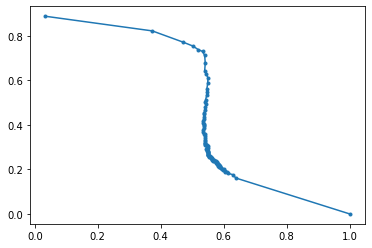

In [197]:
import matplotlib.pyplot as plt

plt.plot(precisions,recalls, label='Precision-Recall curve', marker='.')

In [198]:
def none_fix(x):
    if x==None:
        return "No filter"
    return x
df['filter'] = df.apply(lambda x: none_fix(x['filter']), axis=1)

In [199]:
df.loc[df['filter']=="Has Ans",'recall']=df.loc[df['filter']=="Has Ans",'conf']
df.loc[df['filter']=="Has Ans",'precision']=0

In [200]:
df[df['filter']=="No Ans"]['recall'].max()

0.8221717744986757

In [201]:
# Add final rows
df.loc[len(df.index)] = [0, df[df['filter']=="No Ans"]['recall'].max()+0.0001, 0.0001, "No Ans"]
df.loc[len(df.index)] = [0, df[df['filter']=="Has Ans"]['recall'].max()+0.0001, 0.0001, "Has Ans"]

In [202]:
df.loc[len(df.index)] = [0, 1, 0.00001, "No Ans"]
df.loc[len(df.index)] = [0, 1, 0.00001, "Has Ans"]

In [203]:
import plotly.express as px

fig = px.line(df, x="recall", y="precision", color='filter', width=600, height=400)
fig.show()

In [204]:
from evaluate import get_preds, compute_precision_recall

In [228]:
category = None
import numpy as np

precisions = [1]
recalls = [0]
ln = []
normal_check = []
confs = []
for conf in list(np.arange(0.99, 0, -0.01)) + [0.001, 0]:
    conf_thresh_pred_dict = get_preds(pred_dict, conf)
    prec, recall = compute_precision_recall(
        gt_dict, conf_thresh_pred_dict, category=category)
    precisions.append(prec)
    recalls.append(recall)
    confs.append(conf)

    mn = np.mean([len(x) for x in list(conf_thresh_pred_dict.values())])
    std = np.std([len(x) for x in list(conf_thresh_pred_dict.values())])
    ln.append((mn,std))
    if recall>0.75 and recall<0.85:
        normal_check.extend([len(x) for x in list(conf_thresh_pred_dict.values())])

### Expected predictions

Single contract plot

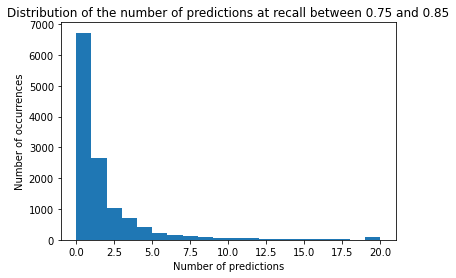

In [231]:
plt.hist(normal_check, bins=20)
plt.xlabel("Number of predictions")
plt.ylabel("Number of occurrences")
plt.title("Distribution of the number of predictions at recall between 0.75 and 0.85")
plt.savefig('distribution_preds_recall_0.75_0.85.png')
plt.show()

In [214]:
import plotly.graph_objects as go
import numpy as np


x = recalls[1:]
x_rev = x[::-1]

# Line 1
y1 = np.array([x[0] for x in ln])
std1 = np.array([x[1] for x in ln])
y1_upper = y1-std1
y1_lower = y1+std1
y1_lower = y1_lower[::-1]
y1_upper = list(y1_upper)
y1_lower = list(y1_lower)
y1=list(y1)


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Number of predictions',
))

fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    showlegend=False,
))
fig.update_traces(mode='lines')
fig.update_layout(width=600, height=400)
fig.update_xaxes(title_text='Recall')
fig.update_yaxes(title_text='# of predictions')
fig.show()

In [139]:
potentials = os.listdir('./NotebookData/preds_server/experiment_data_transf/predictions/')
potentials = [x for x in potentials if (int(x.split('global-step_')[1].split('_')[0])>2500) and ('nbest_predictions' in x    )]
len(potentials)

44

### Multiple runs predictions

Tried to do it based on multiple runs, but to plot the recall one would need to interpolate the values as they don't have the same x-axis thus the confidence intervals are used

In [152]:
gt_dict_extract_answers=True
n_best_predictions_paths = ['./NotebookData/preds_server/experiment_data_transf/predictions/' + x for x in potentials]
category = None
from tqdm import tqdm

# DF
data = []
for filtern in ["No Ans", None]:
    with open ('../../data/test_full.json', 'r') as f:
        gt_dict = json.load(f)
    gt_dict = get_answers(gt_dict) if gt_dict_extract_answers else gt_dict
    to_rm = []
    if filtern == "No Ans":
        to_rm = [k for k, v in gt_dict.items() if not v]
        print("Removing {} examples with empty answers".format(len(to_rm)))
    elif filtern == "Has Ans":
        to_rm = [k for k, v in gt_dict.items() if v]
        print("Removing {} examples with answers".format(len(to_rm)))

    for idx, n_best_predictions_path in tqdm(enumerate(n_best_predictions_paths), total=len(n_best_predictions_paths), desc="Calculating precisions"):
        pred_dict = load_json(n_best_predictions_path)
        # Remove examples
        for k in to_rm:
            gt_dict.pop(k, None)
            pred_dict.pop(k, None)
        assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

        precisions = []
        recalls = []
        ln = []
        confs = []
        for conf in list(np.arange(0.99, 0, -0.01)) + [0.001, 0]:
            conf_thresh_pred_dict = get_preds(pred_dict, conf)
            prec, recall = compute_precision_recall(
                gt_dict, conf_thresh_pred_dict, category=category)
            precisions.append(prec)
            recalls.append(recall)
            confs.append(conf)

            mn = np.mean([len(x) for x in list(conf_thresh_pred_dict.values())])
            std = np.std([len(x) for x in list(conf_thresh_pred_dict.values())])
            ln.append((mn,std))

        for p,r,c, l in zip(precisions, recalls, confs, ln):
            # precision, recall, conf, mean, std, filter, n_best_pred_id, n_best_pred_path, unique_id
            data.append([p,r,c,l[0],l[1],filtern, idx, n_best_predictions_path, str(filtern)+'_'+str(idx)])
        if idx>3:
            break

Removing 2938 examples with empty answers


Calculating precisions:   9%|▉         | 4/44 [00:54<09:01, 13.54s/it]


In [153]:
str(None)

'None'

In [154]:
# Create dataframe from data
import pandas as pd
df = pd.DataFrame(data, columns=['precision', 'recall', 'conf', 'mean', 'std', 'filter', 'n_best_idx', 'n_best_pred_path', 'pred_combi_id'])

In [162]:
def none_fix(x):
    if x==None:
        return "No filter"
    return x
df['filter'] = df.apply(lambda x: none_fix(x['filter']), axis=1)
df.to_csv('data_model_prec_recall.csv')


,precision,recall,conf,mean,std,filter,n_best_idx,n_best_pred_path,pred_combi_id
0,0.971223,0.153235,0.990,0.334405,0.471782,No Ans,0,../../notebooks/NotebookData/preds_server/expe...,No Ans_0
1,0.969163,0.166477,0.980,0.364148,0.481190,No Ans,0,../../notebooks/NotebookData/preds_server/expe...,No Ans_0
2,0.962887,0.176693,0.970,0.388264,0.487355,No Ans,0,../../notebooks/NotebookData/preds_server/expe...,No Ans_0
3,0.960000,0.181612,0.960,0.400322,0.489963,No Ans,0,../../notebooks/NotebookData/preds_server/expe...,No Ans_0
4,0.958661,0.184260,0.950,0.406752,0.491228,No Ans,0,../../notebooks/NotebookData/preds_server/expe...,No Ans_0
...,...,...,...,...,...,...,...,...,...
1005,0.420180,0.795687,0.030,1.500956,2.639666,No filter,4,../../notebooks/NotebookData/preds_server/expe...,None_4
1006,0.398105,0.810821,0.020,1.628886,2.890230,No filter,4,../../notebooks/NotebookData/preds_server/expe...,None_4
1007,0.363199,0.828226,0.010,1.834290,3.238273,No filter,4,../../notebooks/NotebookData/preds_server/expe...,None_4
1008,0.258825,0.860008,0.001,2.664036,4.324725,No filter,4,../../notebooks/NotebookData/preds_server/expe...,None_4


In [163]:
df_1 = df[df['filter']=="No Ans"]
df_2 = df[df['filter']!="No Ans"]

In [165]:
df_g = df.groupby(['filter','conf']).agg({'mean':'mean', 'recall':'mean','std':'mean','precision':'count'})

In [172]:
df_g.reset_index(inplace=True)

In [185]:
import plotly.graph_objects as go
import numpy as np

df_1 = df_g[df_g['filter']=="No Ans"]
df_2 = df_g[df_g['filter']!="No Ans"]

x = list(df_1.conf)
x_rev = x[::-1]

# Line 1
y1 = df_1['mean']
y1_std = df_1['std']
y1_upper = (y1+y1_std).to_list()
y1_lower = y1-y1_std
y1_lower = y1_lower[::-1]

y1_lower = y1_lower.to_list()
y1 = y1.to_list()

# Line 2
y2 = df_2['mean']
y2_std = df_2['std']
y2_upper = y2-y2_std
y2_lower = y2+y2_std
y2_lower = y2_lower[::-1]

# to list
y2_lower = y2_lower.to_list()
y2 = y2.to_list()
y2_upper = y2_upper.to_list()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    name='Premium',
    showlegend=False,
))

fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x, y=y2,
    line_color='rgb(0,176,246)',
    name='Premium',
))

fig.update_traces(mode='lines')
fig.show()

Single prediction analysis